# Exploratory Data Analysis

I randomly sampled 100 treatment plans by changing the DoseValue parameter for five OARs:
* SpinalCanal
* Heart
* Rib
* Chestwall_L
* Lungs

I recorded DoseValue parameters used, dose statistics, and clinical goal values for each plan and each OAR (including the PTV).
My main goal was to see if there are any clear correlations between the different ROIs, primarily so that we can design a better kernel for the Gaussian processes used in our Bayesian optimization.

### Objective function terms

Objective function terms can be accessed with the following code:
```python
import connect
plan = connect.get_current('Plan')
funcs = plan.PlanOptimizations[0].Objective.ConstituentFunctions
```

Relevant values for the ``ii``th term can be found here:
```python
funcs[ii].ForRegionOfInterest.Name
funcs[ii].DoseFunctionParameters.FunctionType
funcs[ii].DoseFunctionParameters.DoseLevel
funcs[ii].DoseFunctionParameters.PercentVolume
funcs[ii].DoseFunctionParameters.Weight
```

The following are the parameters used for the approved plan:

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | SpinalCanal | Max Dose 2080 cGy | MaxDose | 2080 | 95 | 90
2 | Heart | Max Dose 2800 cGy | MaxDose | 2800 | 95 | 90
6 | Rib | Max Dose 3200 cGy | MaxDose | 3200 | 95 | 90
8 | PTV | Max Dose 6240 cGy | MaxDose | 6240 | 0 | 95
9 | PTV | Min Dose 4800 cGy | MinDose | 4800 | 0 | 100
10 | Chestwall_L | Max DVH 3000 cGy to 1.5% volume | MaxDvh | 3000 | 1.5 | 90
11 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 90


##### Note:
There were some discrepancies when I looked into values the day after I did the sampling for ``samples_6_4.npy``.
The DoseLevel values look like the optimal values from my previous Bayesian search, but the PercentVolume wasn't something I was modifying.
Now I'm not sure if I sampled everything with the wrong PercentVolume for the lungs. 
* SpinalCanal DoseLevel = 1040
* Rib DoseLevel = 1600
* Chestwall_L DoseLevel = 1784
* Lungs DoseLevel = 1000, PercentVolume = 8

For the samples in ``samples_6_5.npy``, I made sure to reset all of the parameters, and I fixed the problem with saving the parameter values.

### Dose Statistics

Dose statistics can be accessed with the following code:
```python
dose = plan.TreatmentCourse.TotalDose
dose.GetDoseStatistic(RoiName=roi, DoseType='Min')
dose.GetDoseStatistic(RoiName=roi, DoseType='Average')
dose.GetDoseStatistic(RoiName=roi, DoseType='Max')
dose.GetDoseAtRelativeVolumes(RoiName=roi, RelativeVolumes=[0.99, 0.98, ...])
dose.GetRelativeVolumeAtDose(RoiName=roi, DoseValues=np.linspace(0, max_dose, 100))
```

### Clinical goals

Clinical goals can be accessed with the following code:
```python
goals = plan.TreatmentCourse.EvaluationSetup.EvaluationFunctions
```

Relevant values for the ``ii``th term can be found here:
```python
goals[ii].ForRegionOfInterest.Name
goals[ii].PlanningGoal.Type
goals[ii].PlanningGoal.GoalCriteria
goals[ii].PlanningGoal.AcceptanceLevel
goals[ii].PlanningGoal.ParameterValue
goals[ii].GetClinicalGoalValue()
```

The following goals are used for the approved plan:

idx | Name | Description | Type | GoalCriteria | AcceptanceLevel | ParameterValue
-|-|-|-|-|-|-
2 | Heart | At most 3400 cGy dose at 0 cm$^3$ volume | DoseAtAbsoluteVolume | AtMost | 3400 | 0
3 | Heart | At most 15 cm$^3$ volume at 2800 cGy dose | AbsoluteVolumeAtDose | AtMost | 15 | 2800
8 | Lungs | At most 1500 cm$^3$ volume at 1160 cGy dose | AbsoluteVolumeAtDose| AtMost | 1500 | 1160
9 | Lungs | At most 10 % volume at 2000 cGy dose | VolumeAtDose | AtMost | 0.1 | 2000
11 | SpinalCanal |  At most 2080 cGy dose at 0.35 cm$^3$ volume | DoseAtAbsoluteVolume| AtMost | 2080 | 0.35
14 | Rib | At most 1 cm$^3$ volume at 3200 cGy dose | AbsoluteVolumeAtDose | AtMost | 1 | 3200
15 | Rib | At most 4000 cGy dose at 0.04 cm$^3$ volume | DoseAtAbsoluteVolume | AtMost | 4000 | 0.035
18 | Chestwall_L | At most 30 cm$^3$ volume at 3000 cGy dose | AbsoluteVolumeAtDose | AtMost | 30 | 3000
19 | PTV | At least 95 % volume at 4800 cGy dose | VolumeAtDose | AtLeast | 0.95 | 4800
20 | PTV | At least 99 % volume at 4320 cGy dose | VolumeAtDose | AtLeast | 0.99 | 4320

### Results Format

Dose Parameters
```python
{ Name : [{'idx', 'DoseLevel', 'Range'}] }
```

Dose Statistics
```python
{ Name : {'Min', 'Max', 'Average', 'D99', 'D98', 'D95', 'D50', 'D5', 'D2','D1'} }
```

Clinical Goals
```python
{ Name : [{ 'idx', 'GoalCriteria', 'AcceptanceLevel', 'GoalValue' }] }
```

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [415]:
# Load sampled treatment plans
samples = np.load('samples_6_5.npy', allow_pickle=True)

# Dose parameters

In [ ]:
def roi_pars(samples, roi):
    """Create list of sampled ROI DoseLevel parameters."""
    par_list = []
    for ii in range(len(samples[0][0][roi])):
        par_list.append([samples[jj][0][roi][ii]['DoseLevel'] for jj in range(len(samples))])
    return par_list

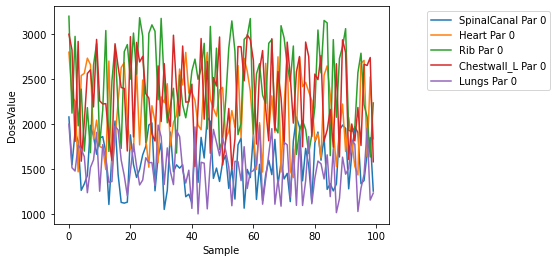

In [416]:
# Plot sampled DoseLevels
oar_list = ['SpinalCanal', 'Heart', 'Rib', 'Chestwall_L', 'Lungs']
labels = []
for oar in oar_list:
    par_list = roi_pars(samples, oar)
    for ii in range(len(par_list)):
        plt.plot(par_list[ii])
        labels.append(f'{oar} Par {ii}')
plt.xlabel('Sample')
plt.ylabel('DoseValue')
plt.legend(labels=labels, bbox_to_anchor=(1.1, 1));

# Something wrong in either sampling DoseLevel parameters or in saving them!
# Update: Fixed by deep copying the dictiories.

# Dose Statistics

In [ ]:
def roi_stats(samples, roi, stat_type):
    """Get list of sampled ROI statistics."""
    return [samples[ii][1][roi][stat_type] for ii in range(len(samples))]

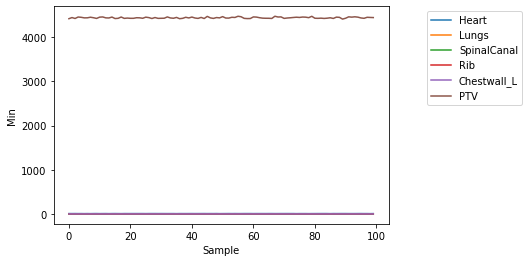

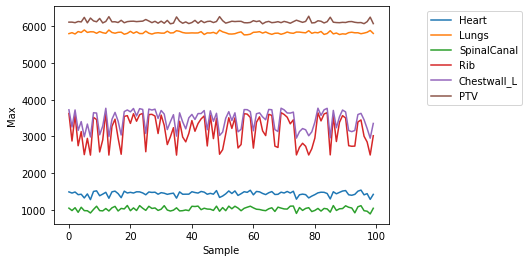

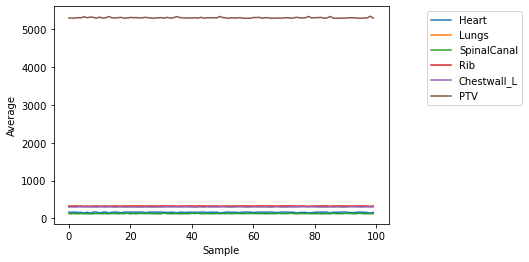

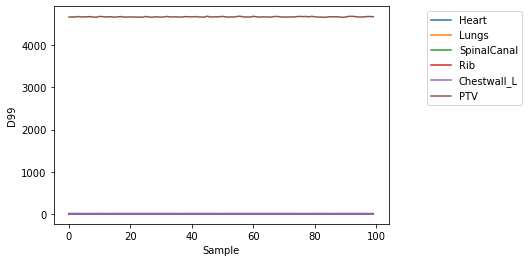

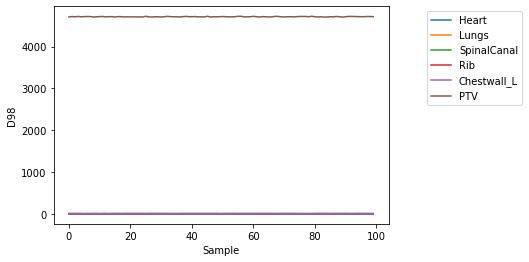

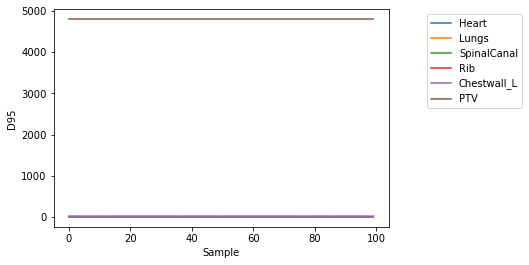

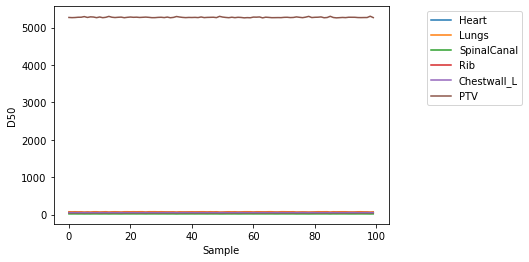

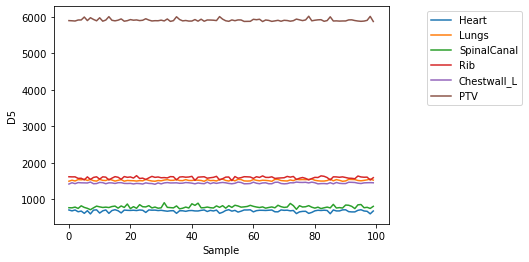

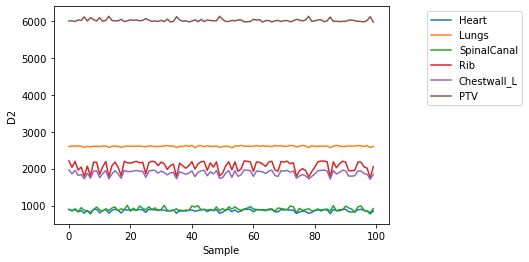

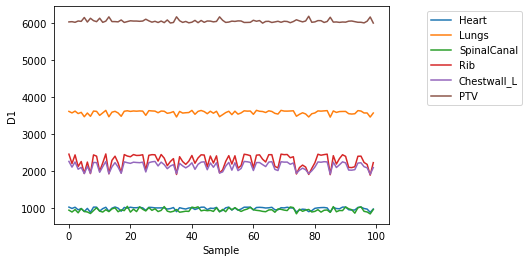

In [417]:
# Plot each statistics for all ROIs
roi_list = ['Heart', 'Lungs', 'SpinalCanal', 'Rib', 'Chestwall_L', 'PTV']
for stat in samples[0][1]['Heart'].keys():
    plt.figure()
    for roi in roi_list:
        plt.plot(roi_stats(samples, roi, stat))
    plt.xlabel('Sample')
    plt.ylabel(stat)
    plt.legend(labels=roi_list, bbox_to_anchor=(1.1, 1))

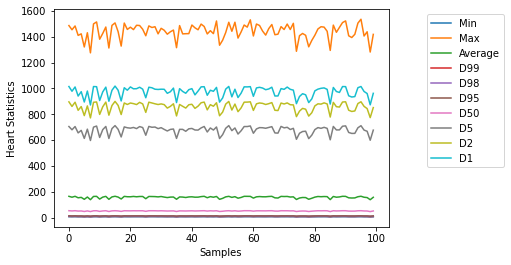

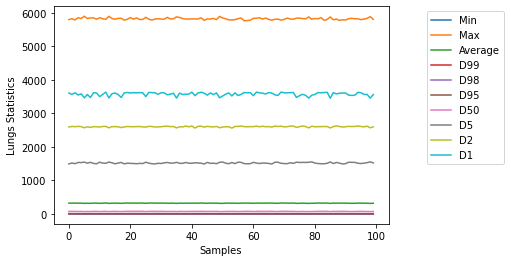

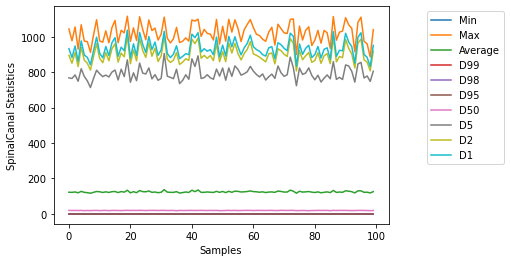

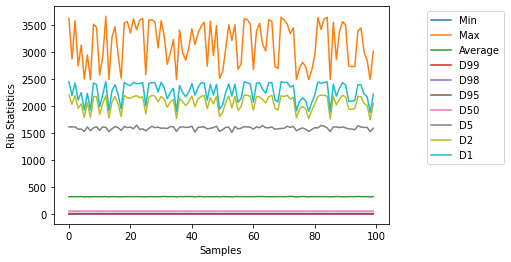

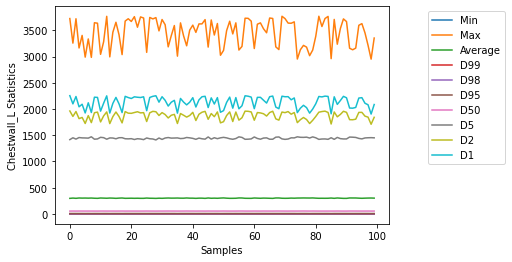

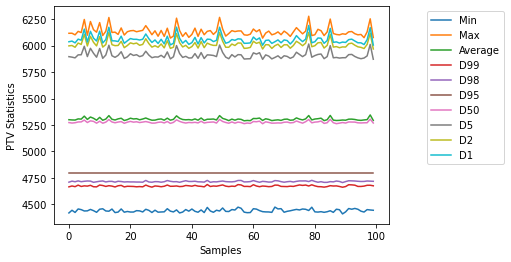

In [418]:
# Plot all statistics for each ROI
for roi in roi_list:
    plt.figure()
    labels = []
    for stat in samples[0][1][roi].keys():
        plt.plot(roi_stats(samples, roi, stat))
        labels.append(stat)
    plt.xlabel('Samples')
    plt.ylabel(f'{roi} Statistics')
    plt.legend(labels=labels, bbox_to_anchor=(1.1, 1))

# Clinical Goals

In [ ]:
def roi_goals(samples, roi):
    """Get list of sampled ROI clinical goal results."""
    goal_list = []
    for ii in range(len(samples[0][2][roi])):
        goal_list.append([goal_percent(samples[jj][2][roi][ii]) for jj in range(len(samples))])
    return goal_list

def goal_percent(goal):
    """Calculate percent change from clinical goal."""
    return (-1)**(goal['GoalCriteria'] == 'AtMost')*(goal['AcceptanceLevel'] - goal['GoalValue'])/goal['AcceptanceLevel']

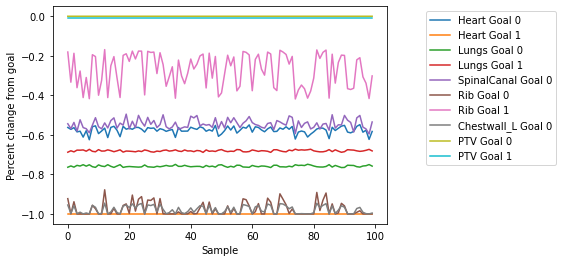

In [419]:
# Plot percent difference from clinical goal
roi_list = ['Heart', 'Lungs', 'SpinalCanal', 'Rib', 'Chestwall_L', 'PTV']
labels = []
for roi in roi_list:
    goal_list = roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        plt.plot(goal_list[ii])
        labels.append(f'{roi} Goal {ii}')
plt.xlabel('Sample')
plt.ylabel('Percent change from goal')
plt.legend(labels=labels, bbox_to_anchor=(1.1, 1))

# Since the PTV doesn't have a goal based on the maximum value, scoring plans based only on
# clinical goals will not be able to limit the maximum dose!

# Covariance and Correlation within Statistics

In [90]:
import pandas as pd
import seaborn as sns

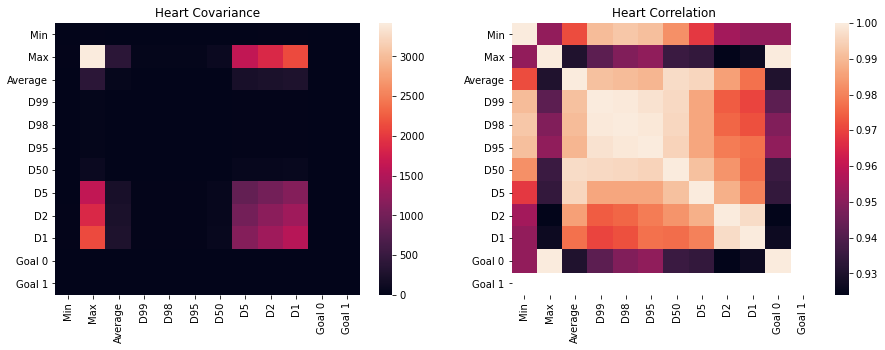

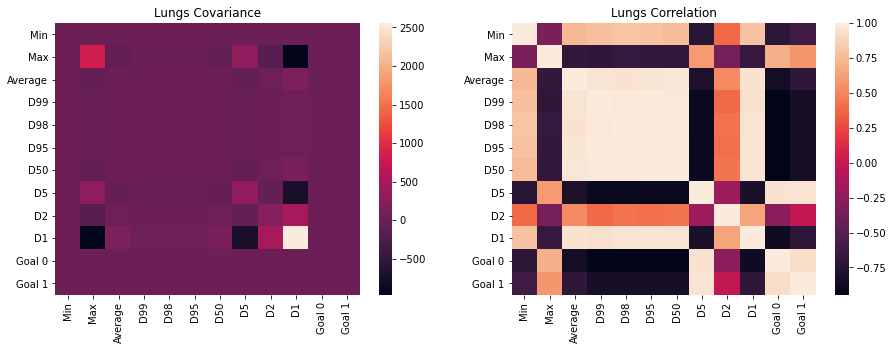

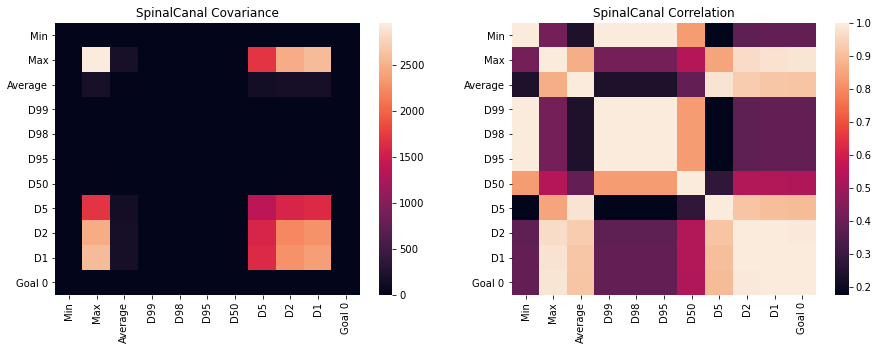

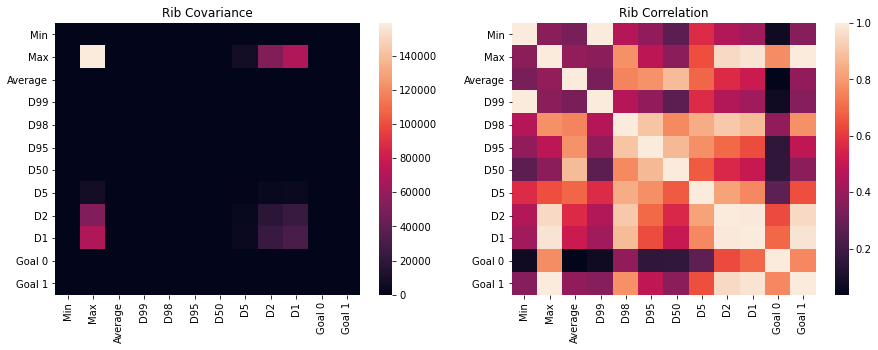

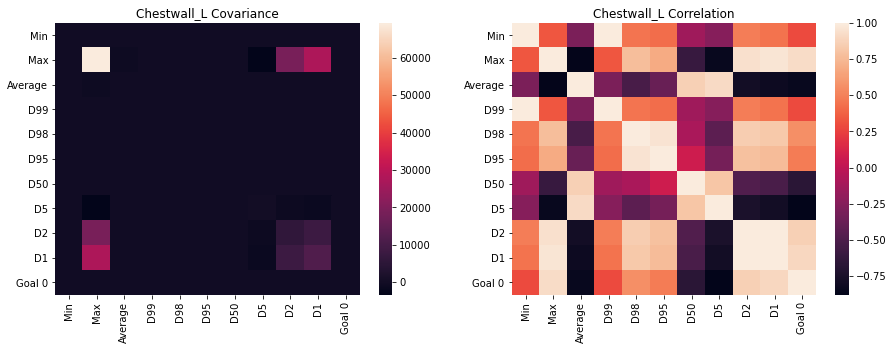

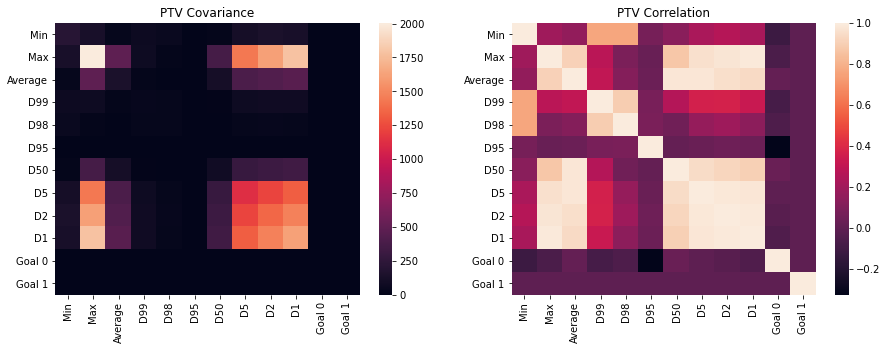

In [420]:
for roi in roi_list:
    # Create DataFrame from dictionary
    roi_dict = {}
    for stat in samples[0][1][roi].keys():
        roi_dict[stat] = roi_stats(samples, roi, stat)
    goal_list = roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        roi_dict[f'Goal {ii}'] = goal_list[ii]
    roi_df = pd.DataFrame(data=roi_dict) 

    # Plot correlation
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    roi_cov = roi_df.cov()
    sns.heatmap(roi_cov, ax=ax[0])
    ax[0].set_title(f'{roi} Covariance');  
    
    # Plot correlation
    roi_corr = roi_df.corr()
    sns.heatmap(roi_corr, ax=ax[1])
    ax[1].set_title(f'{roi} Correlation')
    
# Note: Heart Goal 1 always had value -1, so no variance, so correlation was NaN

# Covariance and Correlation within ROIs

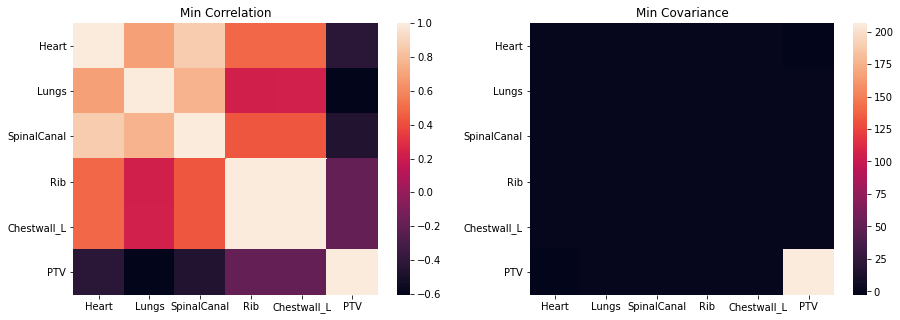

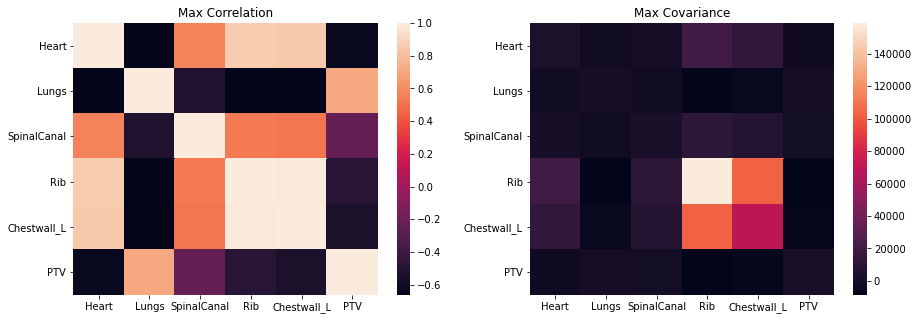

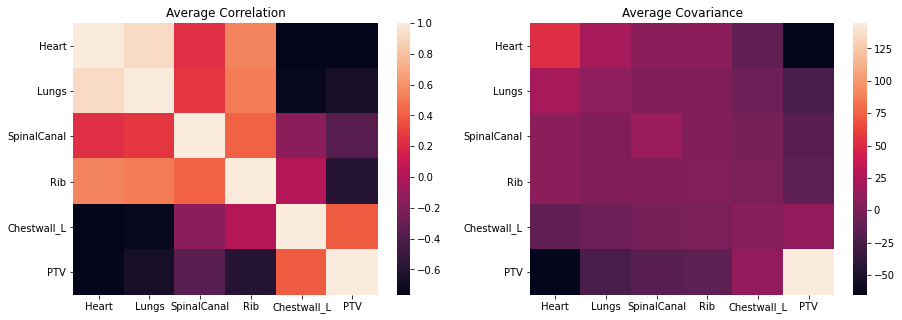

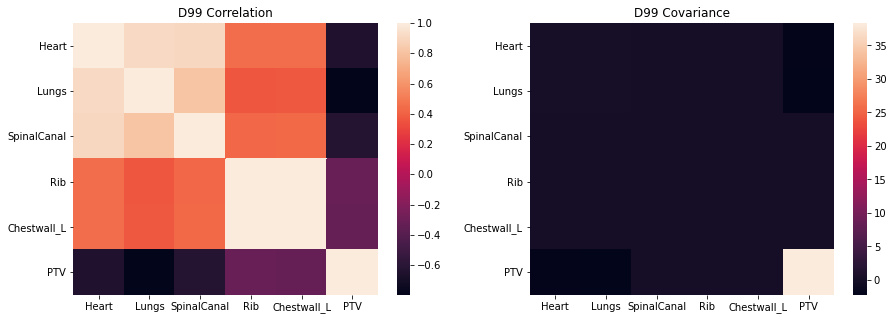

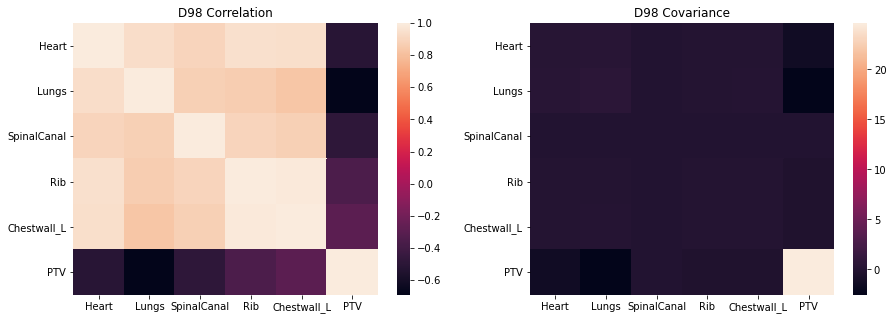

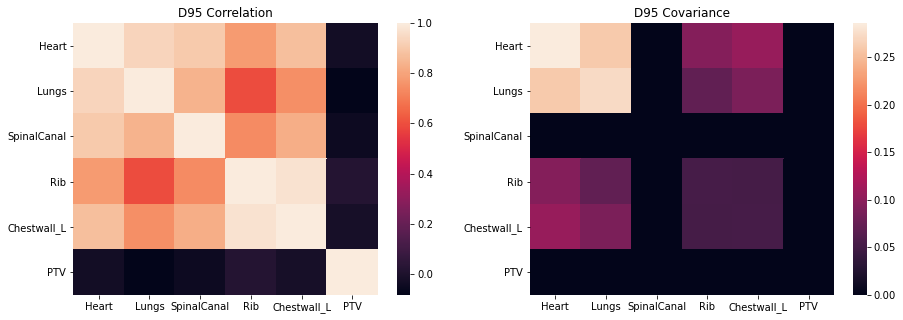

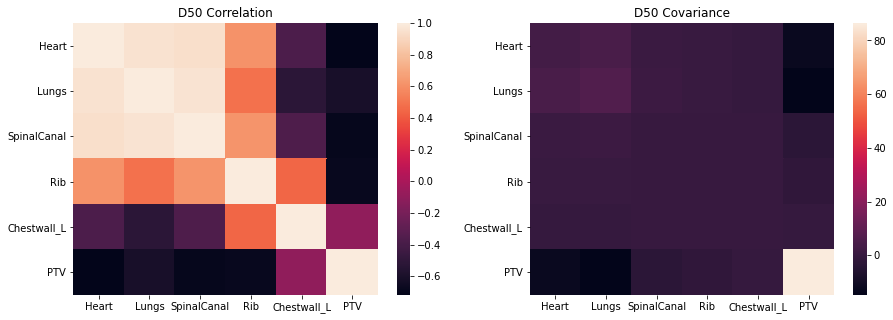

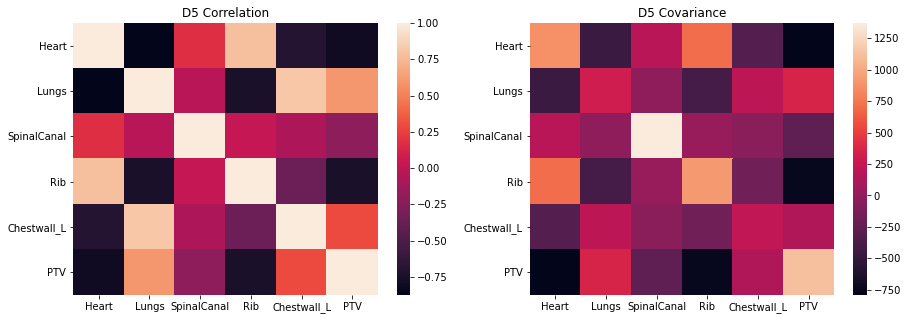

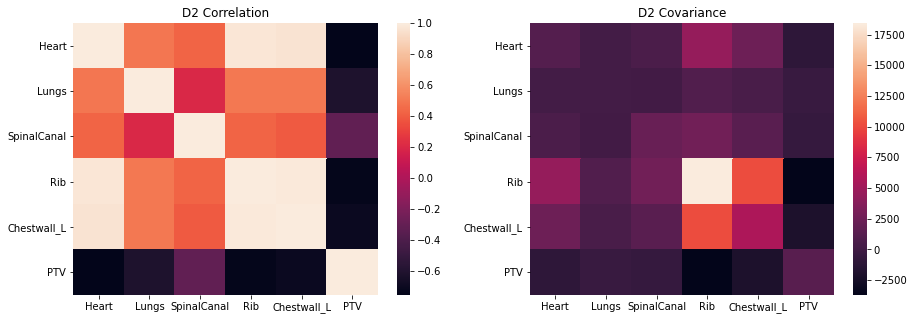

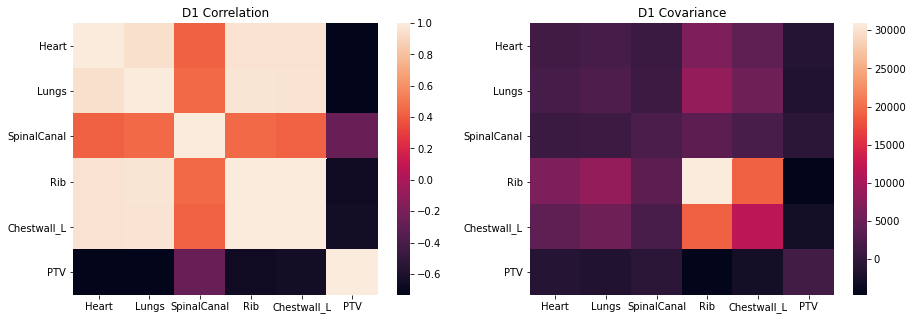

In [421]:
for stat in samples[0][1]['Heart'].keys():
    stat_dict = {}
    for roi in roi_list:
        stat_dict[roi] = roi_stats(samples, roi, stat)
    stat_df = pd.DataFrame(data=stat_dict)

    # Plot correlation
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    stat_corr = stat_df.corr()
    sns.heatmap(stat_corr, ax=ax[0])
    ax[0].set_title(f'{stat} Correlation');
    
    # Plot correlation
    stat_cov = stat_df.cov()
    sns.heatmap(stat_cov, ax=ax[1])
    ax[1].set_title(f'{stat} Covariance');

# Covariance and Correlation with Goals

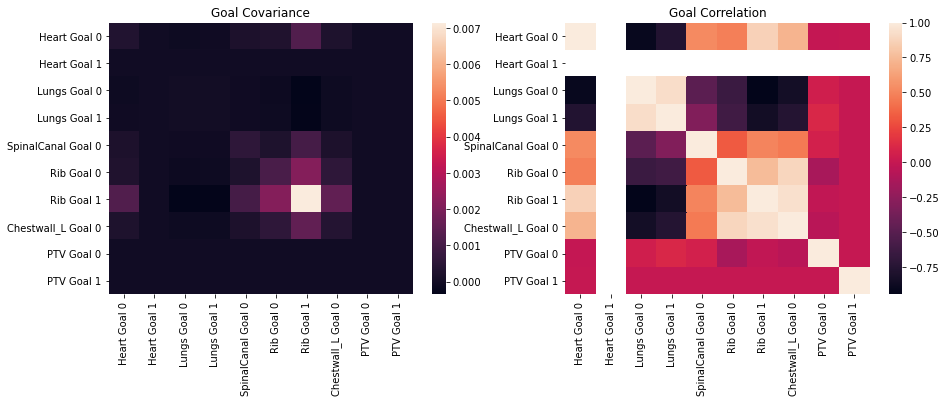

In [422]:
goal_dict = {}
for roi in roi_list:
    # Create DataFrame from dictionary
    goal_list = roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        goal_dict[f'{roi} Goal {ii}'] = goal_list[ii]
    goal_df = pd.DataFrame(data=goal_dict) 

# Plot correlation
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
goal_cov = goal_df.cov()
sns.heatmap(goal_cov, ax=ax[0])
ax[0].set_title(f'Goal Covariance');  

# Plot correlation
goal_corr = goal_df.corr()
sns.heatmap(goal_corr, ax=ax[1])
ax[1].set_title(f'Goal Correlation');

In [156]:
# What is the most interesting thing coming from these results?
# I think what we really want would be the relationships between the parameters and the statistics, or
# the parameters and the goals.

# I think I also need to reformat the data into a DataFrame. I can save in a csv file.

Text(0, 0.5, 'Lungs Average')

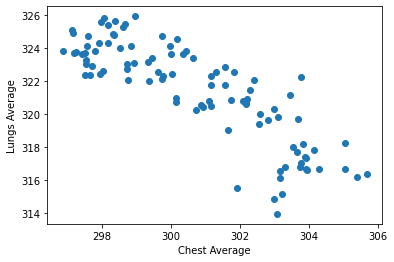

In [177]:
stat = 'Average'
plt.plot(roi_stats(samples, 'Chestwall_L', stat), roi_stats(samples, 'Lungs', stat), 'o')
plt.xlabel(f'Chest {stat}')
plt.ylabel(f'Lungs {stat}')

In [167]:
# What sort of dataframe would I have?
# Rows for trials
# Values ROI, Stat values, Goal values, 

# Forgot to look at other combinations of stats and ROIs

# Multiple dataframes??? like join etc. this might be fun...

In [170]:
# So much depends on the patient geometry, the beam configuration, and the objective function types...

In [171]:
# Giant matrix with all variables? THat woudl be huge, how would you even read it?

In [172]:
# Dashboard where you can see how scores change? Sliders?

In [173]:
# Design an objective function for Bayes that uses conditionals and hierarchy, like
# inf if certain values violated, but others just have penalties

In [174]:
# Could take my data and figure out how many points I need to create a function that looks good
# Then have sliders that change the dose values, and then see the statistics (with mean and variance bars) 
# for the different organs

In [212]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

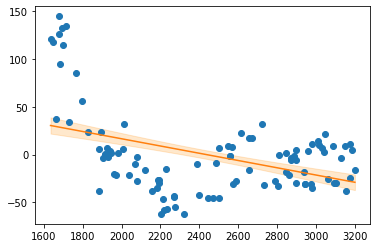

In [433]:
chest = np.array(roi_pars(samples, 'Rib')[0]).reshape(-1, 1)
lung = np.array(roi_stats(samples, 'PTV', 'Max'))

gpr = GaussianProcessRegressor(kernel=kernels.DotProduct(), alpha=np.var(lung)).fit(chest, lung-np.mean(lung))

x_vals = np.linspace(min(chest), max(chest), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

plt.plot(chest, lung-np.mean(lung), 'o')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

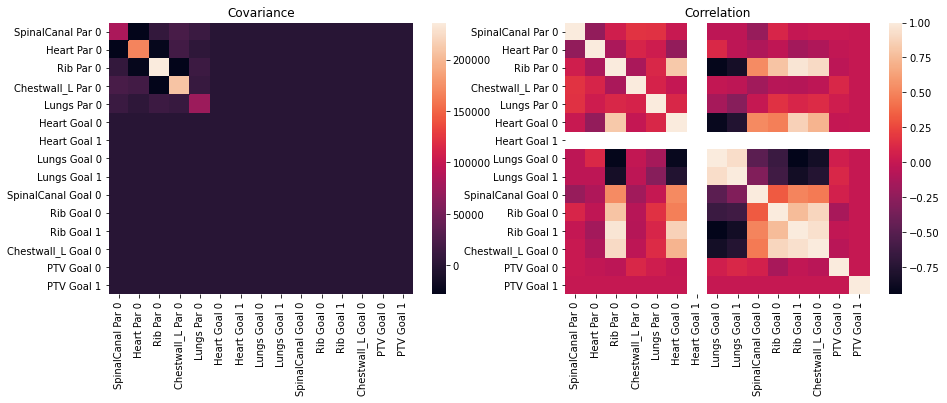

In [434]:
# I want to look at the parameters and the goals!

res_dict = {}

# Add dose parameters
for oar in oar_list:
    par_list = roi_pars(samples, oar)
    for ii in range(len(par_list)):
        res_dict[f'{oar} Par {ii}'] = par_list[ii]

# Add goal values
for roi in roi_list:
    goal_list = roi_goals(samples, roi)
    for ii in range(len(goal_list)):
        res_dict[f'{roi} Goal {ii}'] = goal_list[ii]

# Create DataFrame
res_df = pd.DataFrame(data=res_dict)

# Plot correlation
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
res_cov = res_df.cov()
sns.heatmap(res_cov, ax=ax[0])
ax[0].set_title(f'Covariance');  

# Plot correlation
res_corr = res_df.corr()
sns.heatmap(res_corr, ax=ax[1])
ax[1].set_title(f'Correlation');

(0.0, 5.0)

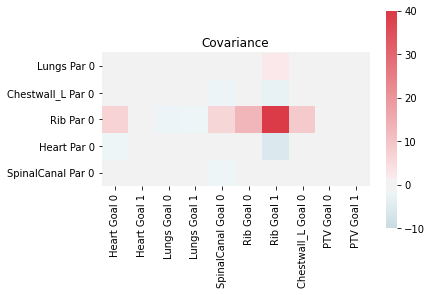

In [592]:
res_cov = res_df.cov()
ax = sns.heatmap(res_cov, vmin=-10, vmax=40, cmap=cmap, center=0, square=True)
ax.set_title(f'Covariance')
ax.set_xlim([5, 15])
ax.set_ylim([0, 5])

Text(0, 0.5, 'Rib Goal 2')

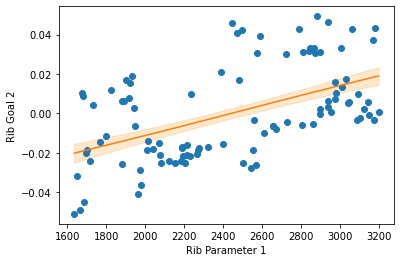

In [588]:


x = np.array(roi_pars(samples, 'Rib')[0]).reshape(-1, 1)
y = np.array(roi_goals(samples, 'SpinalCanal')[0])

gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=np.var(y)).fit(x, y - np.mean(y))

x_vals = np.linspace(min(chest), max(chest), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

plt.plot(x, y - np.mean(y), 'o')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)
plt.xlabel('Rib Parameter 1')
plt.ylabel('Rib Goal 2')

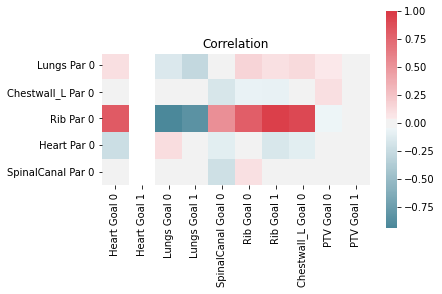

In [596]:
res_corr = res_df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(res_corr, cmap=cmap, center=0, square=True)
ax.set_title(f'Correlation')
ax.set_xlim([5, 15])
ax.set_ylim([0, 4.9]);

In [593]:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

# would like to plot the sized boxes, this seems really nice!

In [ ]:
# Could do both normalized and non-normalized data (would need to run again...)

In [ ]:
# Was going to make a function to interpolate data (or predict with GP),
# Then see how the function varies with it...

# Guessing that the Rib parameter is really the most important here,
# is that still true with the function values?

# Could also plot function vs. parameter value (though it would be a projection since five parameters...)